In [56]:
DATASET_NUM = 0

import pandas as pd

pair_list = ["BTCUSDT","SOLUSDT","ETHUSDT"]
dataset = pd.read_parquet(f"data/dataset_{DATASET_NUM}.parquet")

btc = dataset[dataset.PAIR == "BTCUSDT"]
eth = dataset[dataset.PAIR == "ETHUSDT"]
sol = dataset[dataset.PAIR == "SOLUSDT"]

In [57]:
sol = sol.drop(columns=["PAIR","open","high","low"])
sol.columns

Index(['close', 'volume', 'qav', 'num_trades', 'taker_base_vol',
       'taker_quote_vol'],
      dtype='object')

In [58]:
sol["price_var"] = sol["close"].diff()
lag = 5 

for i in range(1, lag):
    sol[f"price_var_lag_{i}"] = sol["price_var"].shift(i)

sol = sol.iloc[lag:]

In [59]:
sol.head(3)

,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,price_var,price_var_lag_1,price_var_lag_2,price_var_lag_3,price_var_lag_4
2025-04-14 00:05:00,127.11,5706.665,726915.76575,4402.0,1573.849,200491.24502,-0.40,-0.05,0.42,0.22,-0.30
2025-04-14 00:06:00,126.95,3400.370,431687.22745,2832.0,1229.196,156097.70028,-0.16,-0.40,-0.05,0.42,0.22
2025-04-14 00:07:00,126.94,5131.538,651123.87594,1979.0,1339.904,170084.46424,-0.01,-0.16,-0.40,-0.05,0.42


In [60]:
x = sol.drop(columns=["price_var"])
y = sol["price_var"]

Random forest regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Features and target
X = sol.drop(columns=["price_var"])
y = sol["price_var"]

# Drop NaNs caused by lagging
X = X.dropna()
y = y.loc[X.index]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [62]:
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0153
R-squared (R²): 0.3553


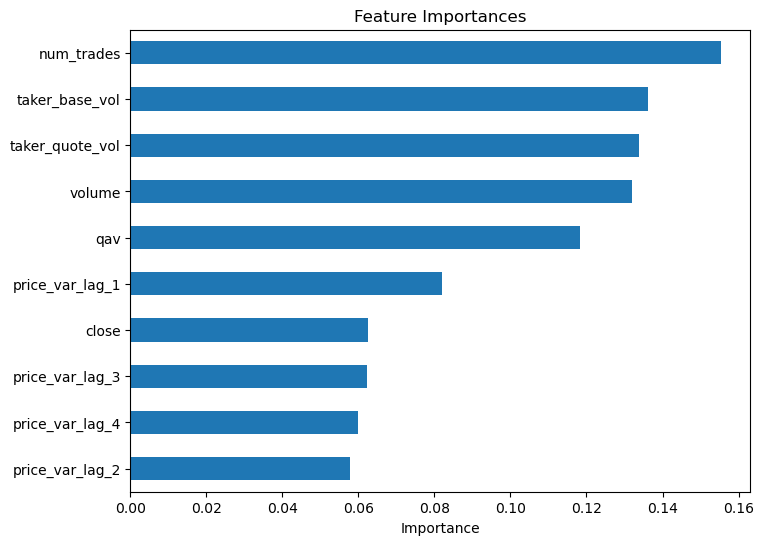

In [63]:
# Feature importances
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

# Sort and plot
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()

## Random forest classifier

In [64]:
sol["target"] = (sol["price_var"] > 0).astype(int)
X = sol.drop(columns=["price_var", "target"])
y = sol["target"]

X = X.dropna()
y = y.loc[X.index]

Accuracy: 0.7183

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1180
           1       0.71      0.71      0.71      1124

    accuracy                           0.72      2304
   macro avg       0.72      0.72      0.72      2304
weighted avg       0.72      0.72      0.72      2304



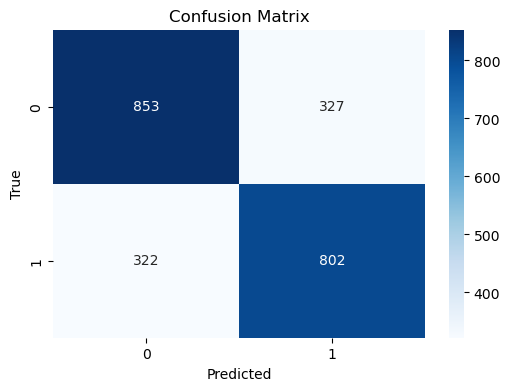

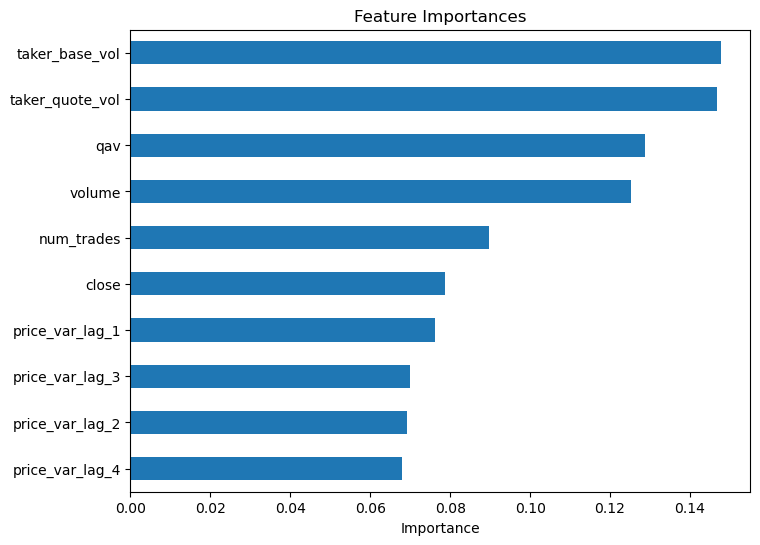

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importances
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()
